In [1]:
import numpy as np

import torch.nn as nn
import torch
import os

import torchvision
from torchvision.utils import save_image
from torchvision.models import vgg19,VGG19_Weights

# Importing image module
import cv2 as cv
import matplotlib.pyplot as plt

# image
from PIL import Image

# garbage collector
import gc

In [2]:
#from munch import Munch
import torch
import torch.nn as nn
import torch.nn.functional as F

# data processing
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms

#from core.wing import FAN
from tqdm.notebook import tqdm

# for importing module
import importlib.util

In [3]:
# defining device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )
cpu = torch.device('cpu' )
print(device)
print( torch.cuda.get_device_name(device) )

cuda
NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
def import_module_by_path(module_path):

    # Provide a custom name for the module
    module_name = "custom_module" 

    # now getting the module
    spec = importlib.util.spec_from_file_location(module_name, module_path)
    custom_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(custom_module)

    return custom_module

## Selective style transfer

In [29]:
from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation

extractor = AutoFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

C:\Users\pcdpm\AppData\Roaming\Python\Python310\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
C:\Users\pcdpm\AppData\Roaming\Python\Python310\site-packages\transformers\models\segformer\image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [30]:
seg_config = model.config

In [50]:
seg_config.label2id['person']

12

In [76]:
# extracted inputs
test_img = Image.open("D:/DISK S/IITM/Clubs/Analytics/Computer Vision/facial feature transfer/images/tamil heros/wed-3.jpg").convert('RGB').resize((256,256))
extracted_inputs = transforms.ToTensor()(test_img).unsqueeze(0)
print(extracted_inputs.shape)

# getting the outputs
segmentation_model = model.to(device)
outputs = segmentation_model(extracted_inputs.to(device))

# getting the logits
logits = upsampled_logits = nn.functional.interpolate(
        outputs.logits,
        size = (256,256),
        mode="bilinear",
        align_corners=False,)

logits = torch.softmax(logits, dim = 1)

# del test_img
# gc.collect()

torch.Size([1, 3, 256, 256])


In [77]:
logits.shape

torch.Size([1, 150, 256, 256])

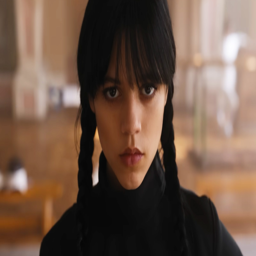

In [79]:
test_img.convert('RGB')

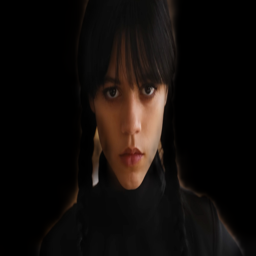

In [84]:
tensor_img = extracted_inputs.to(device) * (logits[:,12,:,:])  
transforms.ToPILImage()(tensor_img[0]).convert('RGB')

In [40]:
extracted_inputs.pixel_values.shape

torch.Size([1, 3, 512, 512])

In [5]:
def image_imposition(original, styled_image, part = ['Hair'], size = (512,512), device = device, show = False, reverse_trans = None, original_trans = None, is_probab = True):

    # getting the index from the label to index
    indexes = [seg_config.label2id[f"{p}"] for p in part]

    # extracted inputs
    if type(original) != torch.Tensor:
        # print('inside wrong')
        extracted_inputs = extractor(images=original, return_tensors="pt")['pixel_values'].to(device)
    else:
        extracted_inputs = original

    # getting the outputs
    outputs = segmentation_model.to(device)(pixel_values = extracted_inputs)
    
    # logits
    logits = outputs.logits

    # getting the logits
    if is_probab == False:
        logits = torch.softmax(logits, dim = 1)
        print(logits.max())

    # up-sampling the logits
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=size,
        mode="bilinear",
        align_corners=False,
    )

    # getting the required mask
    # mask = torch.where( torch.sigmoid(upsampled_logits[:,index,:,:].to(device)) > 0.3, 1.0, 0.0)
    mask = torch.clip(torch.sum(torch.concat([upsampled_logits[:,index,:,:].unsqueeze(1) for index in indexes], dim = 1), dim = 1),0,1).unsqueeze(1)
    print(f"predicted_mask shape : {mask.shape, mask.max()} ")

    # for freeing memory
    del extracted_inputs, outputs
    del logits, upsampled_logits

    # style transforms to get back to normal image from vgg19 transformed image
    if reverse_trans is not None : styled_image = reverse_trans(styled_image)

    # now applying the hadamard product
    # so converting the original image to tensor
    if original_trans is not None: original_image = original_trans(original)
    else: original_image = original

    # print(original_image.shape, styled_image.shape, mask.shape)
    
    # getting the final image
    final_image = original_image * (1-mask) + styled_image.to(device) * (mask)  

    # for memory optimization
    del original_image, styled_image, mask
    gc.collect()
    
    # showing the image
    if show:
        print(final_image.shape)
        # showing only one image
        img = transforms.ToPILImage()(final_image[0]).convert('RGB')
        plt.imshow(img)
        plt.show()
    
    return final_image

In [6]:
def get_selective_style_transfer(image, transformer, save_dir, transformations, reverse_trans, 
                                size, part = ['Hair'], device = device, show = False, is_probab = False):

    # getting the styled_image :
    new_image = transformations(image).unsqueeze(0)

    # styled_image
    style_image = transformer.to(device)(new_image.to(device)).squeeze()

    # getting selective style transfer
    # params : original, styled_image, part = ['Hair'], size = (512,512), device = device, show = False, reverse_trans = None, original_trans = None, is_probab = True
    selective_styled_image = image_imposition(original = new_image, 
                                              styled_image = style_image, 
                                              part = part, 
                                              size = size, 
                                              device = device, 
                                              show = show, 
                                              reverse_trans = reverse_trans,
                                              original_trans = reverse_trans,
                                              is_probab = is_probab)
    
    # saving the image
    if save_dir is not None : 
        os.makedirs(save_dir['dir'], exist_ok = True)
        transforms.ToPILImage()(selective_styled_image).save(f"{save_dir['dir']}/{save_dir['name']}.png")

    return selective_styled_image

## Video style transfer

In [7]:
class video_folder_dataset(Dataset):

    def __init__(self, video = 'video obj', 
                 folder_path = './folder_path', 
                 transformations = transforms.ToTensor(),):

        # initializing variables
        if video is not None : self.video = video
        if folder_path is not None : self.folder = folder_path
        self.transformations = transformations

        # now getting the total frames from the video 
        if video is not None :
            self.len = int(self.video.get(cv.CAP_PROP_FRAME_COUNT))
        else:
            self.video = video
            self.images = []
            # getting all images path in a folder
            for name in os.listdir(folder_path):
                self.images.append( os.path.join(self.folder,name) )
            # length
            self.len = len(self.images)

    def __getitem__(self, index):
        
        if self.video is not None:
            # setting to that frame
            self.video.set(cv.CAP_PROP_POS_FRAMES, index)

            # reading the image
            ret, frame = self.video.read()
            image = Image.fromarray(frame).convert('RGB')
        
        else:
            # getting from the folder
            image = Image.open(self.images[index]).convert('RGB')

        if self.transformations is not None: image = self.transformations(image)
        # returning image
        return image

    def __len__(self):
        return self.len

In [63]:
def bulk_style_transfer(model, video_path, folder_path, batch_size, model_params = {}, selective = None,
                        transformations =  transforms.ToTensor(), reverse_trans = None,
                        save_video = None, save_path = None, is_probab = True):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # getting the dataset
    image_dataset = DataLoader(dataset = video_folder_dataset(video = video_path, 
                                                            folder_path=folder_path,
                                                            transformations= transformations), 
                                                            batch_size = batch_size, shuffle=False, drop_last=False)
    
    transformed_images = []

    try :

        for index,batch in tqdm(enumerate(image_dataset), total = len(image_dataset)):

            # only for real time artistic style transfer
            if index % 24  == 0 :
                s_2 = np.random.randint(0,15)
                s_1 = np.random.randint(0, 15)
                model_params['style_no2'] = None
                model_params['style_no'] = s_1
            
            try :
                # passing the image
                batch = batch.to(device)
                transformed_image = model(batch, **model_params)

                # now doing the selective transformation
                if selective is not None:
                
                    transformed_image = image_imposition(original = batch, styled_image = transformed_image, 
                                                        part = selective, size = batch.shape[-2:], 
                                                        original_trans = reverse_trans,
                                                        device = device, show = False, 
                                                        reverse_trans = reverse_trans,
                                                        is_probab = is_probab)
                else:
                    transformed_image = reverse_trans(transformed_image)
                
                # appending it to the dataset
                transformed_images.append(transformed_image.detach().cpu())
                # print(transformed_image.shape)
                
                # for freeing memory
                del transformed_image, batch
                gc.collect()

            except Exception as e:
                print(f"error {e} at iteration : {index+1}")
                continue  

                # break  

    except Exception as e:
        print(f"error {e}- so ended iteration")  
    
    transformed_images = torch.concat(transformed_images, dim = 0)

    # checking if we need to save a video
    if save_video is not None:

        # object to save video
        h,w = transforms.ToPILImage()(transformed_images[0]).size
        fourcc = cv.VideoWriter_fourcc(*"XVID")
        video_writer = cv.VideoWriter(f"{save_video}.avi", fourcc, 24.0, (h, w)) 

        # writing image
        for img in tqdm(transformed_images):
            img_array = np.array(transforms.ToPILImage()(img).convert('RGB'), dtype = np.uint8)
            video_writer.write(img_array)
        
        # saving image
        video_writer.release()

        return transformed_images

    else:
        # making the dir
        os.makedirs(save_path, exist_ok = True)

        for i,v in tqdm(enumerate(transformed_images), desc = 'saving_images'):
            # saving the images
            transforms.ToPILImage()(v).convert('RGB').save(f"{save_path}style_{model_params['style_no']}_{i}.jpg")
        
        return transformed_images

In [13]:
# # for changing the fps
# from moviepy import editor as editor
# clip = editor.VideoFileClip('./videos/Barbie_Main_Trailer.mp4')
# audio_clip = clip.audio
# print(f"fps of the clip is : {clip.fps}")
# #clip.reader.close()

In [19]:
# clip2 = editor.VideoFileClip('./videos/John_Wick_Chapter 2_Museum_Fight_Scene-0_185.avi')
# clip2.duration

In [29]:
# new_audio_clip = audio_clip.fx(editor.vfx.speedx, 1.276534)
# new_audio_clip.duration

147.82998337686266

In [30]:
# new_audio_clip.write_audiofile('./videos/John_Wick_Chapter 2_Museum_Fight_Scene-0_185_audio.mp3')

MoviePy - Writing audio in ./videos/John_Wick_Chapter 2_Museum_Fight_Scene-0_185_audio.mp3


chunk:   0%|          | 0/3260 [00:00<?, ?it/s, now=None]

MoviePy - Done.


In [48]:
# for cutting video

video = cv.VideoCapture('./videos/TS_Style/TS_WildestDreams.mp4')
fps = video.get(cv.CAP_PROP_FPS)
print(f"fps : {fps}")
total_frames = int(video.get(cv.CAP_PROP_FRAME_COUNT))

start,end = [12*fps, 22*fps]
print(f"total frames : {end - start}")
img_save_path = f"./videos/TS_Style/TS_WildestDreams-{int(start/fps)}_{int(end/fps)}_24_fps.avi"

ret, frame = video.read()
h, w, _ = frame.shape
# h -= 112
print(f"h : {h}  and w : {w}")

fourcc = cv.VideoWriter_fourcc(*"XVID")
trim_video_writer = cv.VideoWriter(img_save_path, fourcc, 24.0, (720, 480) ) 

f = 0
for i in tqdm(range(total_frames), total = total_frames):
    f += 1

    # writing the video
    if start <= f <= end:
        trim_video_writer.write( np.array(Image.fromarray(frame).convert('RGB').resize((720,480)), dtype = np.uint8) )
    elif f > end or ret == False:
        break
    ret, frame = video.read()
    # print(frame.dtype)
    # break

trim_video_writer.release()

# for i in tqdm(range(int(end-start))):

#     # getting the frames
#     frame_index = start + i
#     frame = video.set(cv.CAP_PROP_POS_FRAMES, frame_index)

#     # reading the image and writing it
#     ret, frame = video.read()
#     trim_video_writer.write(frame)

# cap.release()

fps : 23.976023976023978
total frames : 239.7602397602398
h : 720  and w : 1280


  0%|          | 0/5626 [00:00<?, ?it/s]

In [49]:
new_video = cv.VideoCapture(img_save_path)
new_video.get(cv.CAP_PROP_FRAME_COUNT)

240.0

In [50]:
# Artistic style transfer
net_module = import_module_by_path('D:/DISK S/IITM/Clubs/Analytics/Computer Vision/Neural style transfer/Artisitc Style transfer/Real-time-multi-style-transfer/models/PasticheModel.py')
net = net_module.PasticheModel(16).to(device)

# loading model
net.load_state_dict(torch.load('D:/DISK S/IITM/Clubs/Analytics/Computer Vision/Neural style transfer/Artisitc Style transfer/Real-time-multi-style-transfer/pre_trained_models/model/pastichemodel-FINAL.pth',map_location = device))

# # Anime model
# net_module = import_module_by_path('D:/DISK S/IITM/Clubs/Analytics/Computer Vision/Neural style transfer/Anime Gan/My Implementation - Anime Gan v2/source/all_models.py')
# net = net_module.Generator().to(device)

# # loading model
# net.load_state_dict(torch.load("D:/DISK S/IITM/Clubs/Analytics/Computer Vision/Neural style transfer/Anime Gan/My Implementation - Anime Gan v2/weights/face_paint_v2.pt",map_location = device))

print(f"model loaded successfully")

model loaded successfully


In [64]:
# model params
model_params = {'style_no' : -1, "style_no2" : 9, 'alpha' : 0.6}
# model_params = {}

# other params
new_video = new_video

folder_path = None
# folder_path = 'D:/DISK S/IITM/Clubs/Analytics/Computer Vision/facial feature transfer/images/tamil heros'

# for image forward propagation
batch_size = 1
selective = None
size = (480, 720)

# # transformations
# transformations = transforms.Compose([
#     transforms.Resize(size),
#     transforms.ToTensor(),
#     transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
#     # transforms.Normalize(mean = 1, std = 1),
# ])

# reverse_trans = transforms.Compose([
#             transforms.Normalize(mean = 0, std = [1/0.229, 1/0.224, 1/0.225]),
#             transforms.Normalize(mean =  [-0.485, -0.456, -0.406], std = 1),
#             # transforms.ToPILImage(),
        # ])

# reverse_trans = transforms.Compose([
#             transforms.Normalize(mean = 0, std = 1) ])

# transformations
transformations = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean = 0, std = 0.5),
    transforms.Normalize(mean = 1, std = 1),
])

reverse_trans = transforms.Compose([
            transforms.Normalize(mean = -1, std = 1),
            transforms.Normalize(mean = 0, std = 2),
            # transforms.ToPILImage(),
        ])

# save_video = './videos/Rajini/trailer_anime_120_face_protrait'
save_video = f'./videos/TS_Style/styled/TS_WildestDreams_multi_multi_0.6_{int(start/fps)}_{int(end/fps)}'
save_path = None
# save_path = f'D:/DISK S/IITM/Clubs/Analytics/Computer Vision/Neural style transfer/Style Transfered Images/Artistic style transfer/IIT_ Madras/style_{model_params["style_no"]}_'
is_probab = False

In [ ]:
Image.open('D:/DISK S/IITM/Clubs/Analytics/Computer Vision/Neural style transfer/Anime Gan/My Implementation - Anime Gan v2/dataset/dataset/IIT Madras/13.jpg').convert('RGB').resize(size)

In [65]:
transformed_images = bulk_style_transfer(model = net,
                    model_params = model_params,
                    video_path = new_video, 
                    folder_path = folder_path, 
                    batch_size = batch_size, 
                    selective = selective, 
                    transformations =  transformations, 
                    reverse_trans = reverse_trans,
                    save_video = save_video, 
                    save_path = save_path, 
                    is_probab = False)

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

In [104]:
for i in range(0,16):

    # model params
    model_params = {'style_no' : i, "style_no2" : 6, 'alpha' : 0.1}
    
    # path
    save_path = f'D:/DISK S/IITM/Clubs/Analytics/Computer Vision/Neural style transfer/Style Transfered Images/Artistic style transfer/actors/style_{model_params["style_no"]}_/'

    # making style transfer images
    transformed_images = bulk_style_transfer(model = net,
                    model_params = model_params,
                    video_path = new_video, 
                    folder_path = folder_path, 
                    batch_size = batch_size, 
                    selective = selective, 
                    transformations =  transformations, 
                    reverse_trans = reverse_trans,
                    save_video = save_video, 
                    save_path = save_path, 
                    is_probab = False)

  0%|          | 0/32 [00:00<?, ?it/s]

saving_images: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving_images: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving_images: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving_images: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving_images: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving_images: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving_images: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving_images: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving_images: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving_images: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving_images: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving_images: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving_images: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving_images: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving_images: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

saving_images: 0it [00:00, ?it/s]

In [18]:
w,h = transforms.ToPILImage()(transformed_images[0]).size

In [12]:
# object to save video
h,w = size
fourcc = cv.VideoWriter_fourcc(*"XVID")
video_writer = cv.VideoWriter(f"{save_video}.avi", fourcc, 24.0, (w, h)) 

# writing image
for img in tqdm(transformed_images):
    img_array = np.array(transforms.ToPILImage()(img).convert('RGB'), dtype = np.uint8)
    video_writer.write(img_array)
    # break

# saving image
video_writer.release()

In [ ]:
new_video.release()

In [ ]:
video_file = cv.VideoCapture('./videos/Rajini/trailer_anime_89_92.avi')

In [ ]:
transforms.ToPILImage()(transformed_images[70]).convert('RGB').size

(380, 480)

In [7]:
os.listdir('./videos/barbie/styled')

['barbie_14_000_060.avi',
 'barbie_14_060_090.avi',
 'barbie_14_090_120.avi',
 'barbie_14_120_150.avi',
 'barbie_14_150_180.avi',
 'barbie_14_9_0.6_0_60.avi']

In [15]:
# os.listdir('./videos/anime/')
# for joining videos

fourcc = cv.VideoWriter_fourcc(*"XVID")
face_video_writer = cv.VideoWriter('./videos/barbie/styled/14_full.avi', fourcc, 24.0, (w, h)) 

for video_path in tqdm(sorted(os.listdir('./videos/barbie/styled'))[:-1]):
    
    # reading the path
    path = os.path.join('./videos/barbie/styled/',video_path)
    video_obj = cv.VideoCapture(f"{path}") # path

    # now writing the video
    ret = True
    while ret:
        ret, frame = video_obj.read()
        face_video_writer.write(frame)

face_video_writer.release()

  0%|          | 0/6 [00:00<?, ?it/s]

## project euler

In [61]:
# problem - 21

a = [ i+1 for i in range(int(1e4)) ]
d = { i:1 for i in a }

for i,k in enumerate(range(2,100)):

    # getting the multiplayer index
    multiplier_indexes = [ [k*j,j] for j in range(k, int(1e4)//k) ]

    # adding to every index
    for ind,val in multiplier_indexes:
        if val != k : d[ind] += (val+k)
        else: d[ind] += val

print( d[220], ' - working fine ' )

# d2 = {y:x for x,y in d.items()}
sums = 0

for key,val in d.items():

    if val in d and key == d[val] and key != val:
        sums += (key+val)
        print(key,val)

print( sums//2 )

284  - working fine 
220 284
284 220
1184 1210
1210 1184
2620 2924
2924 2620
5020 5564
5564 5020
6232 6368
6368 6232
31626


In [6]:
# Large Sum

nums = """37107287533902102798797998220837590246510135740250
46376937677490009712648124896970078050417018260538
74324986199524741059474233309513058123726617309629
91942213363574161572522430563301811072406154908250
23067588207539346171171980310421047513778063246676
89261670696623633820136378418383684178734361726757
28112879812849979408065481931592621691275889832738
44274228917432520321923589422876796487670272189318
47451445736001306439091167216856844588711603153276
70386486105843025439939619828917593665686757934951
62176457141856560629502157223196586755079324193331
64906352462741904929101432445813822663347944758178
92575867718337217661963751590579239728245598838407
58203565325359399008402633568948830189458628227828
80181199384826282014278194139940567587151170094390
35398664372827112653829987240784473053190104293586
86515506006295864861532075273371959191420517255829
71693888707715466499115593487603532921714970056938
54370070576826684624621495650076471787294438377604
53282654108756828443191190634694037855217779295145
36123272525000296071075082563815656710885258350721
45876576172410976447339110607218265236877223636045
17423706905851860660448207621209813287860733969412
81142660418086830619328460811191061556940512689692
51934325451728388641918047049293215058642563049483
62467221648435076201727918039944693004732956340691
15732444386908125794514089057706229429197107928209
55037687525678773091862540744969844508330393682126
18336384825330154686196124348767681297534375946515
80386287592878490201521685554828717201219257766954
78182833757993103614740356856449095527097864797581
16726320100436897842553539920931837441497806860984
48403098129077791799088218795327364475675590848030
87086987551392711854517078544161852424320693150332
59959406895756536782107074926966537676326235447210
69793950679652694742597709739166693763042633987085
41052684708299085211399427365734116182760315001271
65378607361501080857009149939512557028198746004375
35829035317434717326932123578154982629742552737307
94953759765105305946966067683156574377167401875275
88902802571733229619176668713819931811048770190271
25267680276078003013678680992525463401061632866526
36270218540497705585629946580636237993140746255962
24074486908231174977792365466257246923322810917141
91430288197103288597806669760892938638285025333403
34413065578016127815921815005561868836468420090470
23053081172816430487623791969842487255036638784583
11487696932154902810424020138335124462181441773470
63783299490636259666498587618221225225512486764533
67720186971698544312419572409913959008952310058822
95548255300263520781532296796249481641953868218774
76085327132285723110424803456124867697064507995236
37774242535411291684276865538926205024910326572967
23701913275725675285653248258265463092207058596522
29798860272258331913126375147341994889534765745501
18495701454879288984856827726077713721403798879715
38298203783031473527721580348144513491373226651381
34829543829199918180278916522431027392251122869539
40957953066405232632538044100059654939159879593635
29746152185502371307642255121183693803580388584903
41698116222072977186158236678424689157993532961922
62467957194401269043877107275048102390895523597457
23189706772547915061505504953922979530901129967519
86188088225875314529584099251203829009407770775672
11306739708304724483816533873502340845647058077308
82959174767140363198008187129011875491310547126581
97623331044818386269515456334926366572897563400500
42846280183517070527831839425882145521227251250327
55121603546981200581762165212827652751691296897789
32238195734329339946437501907836945765883352399886
75506164965184775180738168837861091527357929701337
62177842752192623401942399639168044983993173312731
32924185707147349566916674687634660915035914677504
99518671430235219628894890102423325116913619626622
73267460800591547471830798392868535206946944540724
76841822524674417161514036427982273348055556214818
97142617910342598647204516893989422179826088076852
87783646182799346313767754307809363333018982642090
10848802521674670883215120185883543223812876952786
71329612474782464538636993009049310363619763878039
62184073572399794223406235393808339651327408011116
66627891981488087797941876876144230030984490851411
60661826293682836764744779239180335110989069790714
85786944089552990653640447425576083659976645795096
66024396409905389607120198219976047599490197230297
64913982680032973156037120041377903785566085089252
16730939319872750275468906903707539413042652315011
94809377245048795150954100921645863754710598436791
78639167021187492431995700641917969777599028300699
15368713711936614952811305876380278410754449733078
40789923115535562561142322423255033685442488917353
44889911501440648020369068063960672322193204149535
41503128880339536053299340368006977710650566631954
81234880673210146739058568557934581403627822703280
82616570773948327592232845941706525094512325230608
22918802058777319719839450180888072429661980811197
77158542502016545090413245809786882778948721859617
72107838435069186155435662884062257473692284509516
20849603980134001723930671666823555245252804609722
53503534226472524250874054075591789781264330331690"""

sums = 0

for digit in nums.split('\n'):
    if digit != '\n':
        sums += int(digit)

print(str(sums)[:10])

5537376230


In [21]:
1.02*1.02

1.0404

In [28]:
for i in range(1,500):
    if (30**2 + i**2)**0.5 == int( (30**2 + i**2)**0.5 ):
        print(30,i)

30 16
30 40
30 72
30 224
